In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fancyimpute import KNN

Using TensorFlow backend.


In [3]:
# Make a list of files for easy iterating

import glob
patient_files = glob.glob('training/*.psv')
len(patient_files)

5000

In [4]:
# Make the dictionary with first hour of diagnosis of sepsis as keys 
# and number of corresponding people as values 

# Also make a list of files of patients with and without Sepsis

first_hour, sepsis_files, no_sepsis_files = {}, [], []

first_hour['No Sepsis'] = 0
for file in patient_files:
    patient = pd.read_csv(file, sep='|')
    if 1 not in list(patient['SepsisLabel']):
        no_sepsis_files.append(file)
        first_hour['No Sepsis'] += 1
    else:
        sepsis_files.append(file)
        for idx, label in enumerate(patient['SepsisLabel']):
            if label == 1:
                hour = patient.loc[idx]['ICULOS'] 
                if hour not in first_hour:
                    first_hour[hour] = 0
                first_hour[hour] += 1
                break
first_hour

{'No Sepsis': 4721,
 1.0: 56,
 104.0: 2,
 180.0: 1,
 48.0: 2,
 34.0: 2,
 4.0: 5,
 27.0: 6,
 78.0: 2,
 90.0: 3,
 31.0: 1,
 154.0: 1,
 240.0: 1,
 122.0: 2,
 46.0: 2,
 91.0: 1,
 2.0: 6,
 158.0: 1,
 32.0: 4,
 20.0: 2,
 6.0: 5,
 55.0: 2,
 71.0: 2,
 57.0: 1,
 19.0: 4,
 3.0: 7,
 61.0: 3,
 14.0: 6,
 10.0: 1,
 139.0: 2,
 331.0: 1,
 7.0: 8,
 24.0: 5,
 108.0: 1,
 28.0: 3,
 121.0: 1,
 45.0: 3,
 16.0: 3,
 149.0: 1,
 54.0: 2,
 17.0: 2,
 84.0: 4,
 47.0: 3,
 30.0: 5,
 23.0: 4,
 33.0: 2,
 38.0: 2,
 198.0: 2,
 129.0: 1,
 5.0: 4,
 85.0: 1,
 9.0: 4,
 39.0: 3,
 83.0: 2,
 37.0: 2,
 135.0: 1,
 25.0: 2,
 36.0: 1,
 13.0: 5,
 60.0: 1,
 53.0: 2,
 35.0: 2,
 95.0: 1,
 68.0: 1,
 120.0: 1,
 181.0: 1,
 81.0: 2,
 40.0: 3,
 123.0: 2,
 243.0: 1,
 41.0: 1,
 21.0: 1,
 52.0: 2,
 29.0: 1,
 209.0: 1,
 62.0: 1,
 92.0: 2,
 63.0: 1,
 26.0: 3,
 75.0: 1,
 42.0: 1,
 155.0: 1,
 100.0: 1,
 156.0: 1,
 74.0: 1,
 79.0: 1,
 110.0: 2,
 251.0: 1,
 196.0: 1,
 12.0: 2,
 101.0: 1,
 69.0: 1,
 18.0: 2,
 93.0: 1,
 44.0: 1,
 224.0: 1,
 300.0: 1,

In [5]:
len(sepsis_files)

279

In [6]:
x = pd.read_csv(sepsis_files[15], sep='|')
x

HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  BaseExcess  HCO3  \
0    NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN         NaN   NaN   
1   77.0   93.0   NaN  133.0  74.0  56.0  21.0    NaN         NaN   NaN   
2   79.0   91.0   NaN  133.0  82.0  67.0  20.0    NaN         NaN   NaN   
3   78.0   98.0  36.1  127.0  77.0  60.0  18.0    NaN         NaN   NaN   
4   81.0   95.0   NaN  127.0  81.0  65.0   NaN    NaN         NaN   NaN   
5   84.0   97.0   NaN  146.0  80.0  59.0  23.0    NaN         NaN   NaN   
6   82.0    NaN   NaN  133.0  76.0  59.0   NaN    NaN         NaN   NaN   
7   80.0   93.0   NaN  116.0  71.0  54.0  24.0    NaN         NaN   NaN   
8   89.0   92.0   NaN  120.0  68.0  49.0  18.0    NaN         NaN   NaN   
9    NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN         NaN   NaN   
10  81.0   96.0   NaN    NaN   NaN   NaN   NaN    NaN         NaN   NaN   

       ...        WBC  Fibrinogen  Platelets  Age  Gender  Unit1  Unit2  \
0      ...        NaN         NaN        NaN   75       1      0      1   
1      ...        NaN         NaN        NaN   75       1      0      1   
2      ...        NaN         NaN        NaN   75       1      0      1   
3      ...        NaN         NaN        NaN   75       1      0      1   
4      ...       11.3         NaN      523.0   75       1      0      1   
5      ...        NaN         NaN        NaN   75       1      0      1   
6      ...        NaN         NaN        NaN   75       1      0      1   
7      ...        NaN         NaN        NaN   75       1      0      1   
8      ...        NaN         NaN        NaN   75       1      0      1   
9      ...        NaN         NaN        NaN   75       1      0      1   
10     ...        NaN         NaN        NaN   75       1      0      1   

    HospAdmTime  ICULOS  SepsisLabel  
0       -593.74       1            0  
1       -593.74       2            1  
2       -593.74       3            1  
3       -593.74       4            1  
4       -593.74       5            1  
5       -593.74       6            1  
6       -593.74       7            1  
7       -593.74       8            1  
8       -593.74       9            1  
9       -593.74      10            1  
10      -593.74      11            1  

[11 rows x 41 columns]

In [7]:
new_first_hour = defaultdict(int)
for hour in list(first_hour.keys())[1:]:
    if hour <= 19:
        new_first_hour['0-20 Hours'] +=first_hour[hour]
        
    if hour >=20 and hour <= 39:
        new_first_hour['20-40 Hours'] +=first_hour[hour]
    
    if hour >=40 and hour <= 59:
        new_first_hour['40-60 Hours'] +=first_hour[hour]
    
    if hour >=60 and hour <= 79:
        new_first_hour['60-80 Hours'] +=first_hour[hour]
    
    if hour >=80 and hour <= 99:
        new_first_hour['80-100 Hours'] +=first_hour[hour]
    
    if hour >=100 and hour <= 119:
        new_first_hour['100-119 Hours'] +=first_hour[hour]
    
    if hour >=120 and hour <= 139:
        new_first_hour['120-140 Hours'] +=first_hour[hour]
    
    if hour >=140 and hour <= 159:
        new_first_hour['140-160 Hours'] +=first_hour[hour]
    
    if hour >=160 and hour <= 179:
        new_first_hour['160-180 Hours'] +=first_hour[hour]
    
    if hour >=180 and hour <= 199:
        new_first_hour['180-200 Hours'] +=first_hour[hour]
    
    if hour >=200:
        new_first_hour['200+ Hours'] +=first_hour[hour]
        
new_first_hour

defaultdict(int,
            {'0-20 Hours': 123,
             '100-119 Hours': 10,
             '180-200 Hours': 6,
             '40-60 Hours': 28,
             '20-40 Hours': 51,
             '60-80 Hours': 17,
             '80-100 Hours': 19,
             '140-160 Hours': 5,
             '200+ Hours': 10,
             '120-140 Hours': 10})

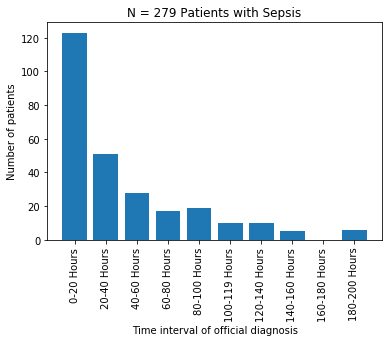

In [8]:
# Bar plot that shows how many hours after ICU admission do patients get official sepsis diagnosis

order = ['0-20 Hours', '20-40 Hours', '40-60 Hours', '60-80 Hours', '80-100 Hours',
        '100-119 Hours', '120-140 Hours', '140-160 Hours', '160-180 Hours', '180-200 Hours']
count = [new_first_hour[interval] for interval in order]

plt.bar(order,count)
plt.xticks(rotation=90)
plt.title('N = 279 Patients with Sepsis')
plt.xlabel('Time interval of official diagnosis')
plt.ylabel('Number of patients')
plt.show()

In [9]:
# EXAMPLE 
test = pd.read_csv(sepsis_files[20], sep='|')
test

HR  O2Sat  Temp    SBP    MAP   DBP  Resp  EtCO2  BaseExcess  HCO3  \
0     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN         NaN   NaN   
1   112.0   89.0   NaN  142.0  121.0  96.0  26.0    NaN         NaN   NaN   
2   108.0   89.0   NaN  127.0   86.0  70.0  23.0    NaN         NaN   NaN   
3   106.0   89.5   NaN  107.5   89.5  73.0   NaN    NaN         NaN   NaN   
4   105.0   85.0   NaN  117.5   92.0  75.0  33.5    NaN         NaN   NaN   
5   116.0   85.0   NaN   99.0   88.0  76.0  32.0    NaN         NaN   NaN   
6   106.0   86.0   NaN  111.0   60.0  45.0  36.0    NaN         NaN   NaN   
7   110.0   83.0  36.8  119.0   96.0  79.0  38.0    NaN         NaN   NaN   
8   117.0   93.5  36.7  108.5   87.0  65.5   NaN    NaN         NaN   NaN   
9   126.0   83.0  37.2  127.5   78.0  67.5  19.0   35.0         NaN   NaN   
10  134.0   83.5  37.2  113.0   85.5  80.0  18.0   38.0         NaN   NaN   
11  134.0   89.0   NaN  102.0   78.0  59.0   NaN   38.0         NaN   NaN   
12  123.0  100.0  37.2  108.5   72.0  54.5  22.0    NaN         NaN   NaN   
13  119.0   99.5  37.3  105.0   91.5  73.5   NaN    NaN         NaN   NaN   
14  117.0  100.0   NaN   81.5   64.0  49.5   NaN    NaN         NaN   NaN   

       ...        WBC  Fibrinogen  Platelets  Age  Gender  Unit1  Unit2  \
0      ...        NaN         NaN        NaN   67       0      1      0   
1      ...        NaN         NaN        NaN   67       0      1      0   
2      ...       12.7         NaN      167.0   67       0      1      0   
3      ...        NaN         NaN        NaN   67       0      1      0   
4      ...        NaN         NaN        NaN   67       0      1      0   
5      ...        NaN         NaN        NaN   67       0      1      0   
6      ...        NaN         NaN        NaN   67       0      1      0   
7      ...        NaN         NaN        NaN   67       0      1      0   
8      ...        NaN         NaN        NaN   67       0      1      0   
9      ...        NaN         NaN        NaN   67       0      1      0   
10     ...        NaN         NaN        NaN   67       0      1      0   
11     ...        NaN         NaN        NaN   67       0      1      0   
12     ...        NaN         NaN        NaN   67       0      1      0   
13     ...        NaN         NaN        NaN   67       0      1      0   
14     ...        NaN         NaN        NaN   67       0      1      0   

    HospAdmTime  ICULOS  SepsisLabel  
0         -0.12       1            0  
1         -0.12       2            0  
2         -0.12       3            0  
3         -0.12       4            0  
4         -0.12       5            0  
5         -0.12       6            1  
6         -0.12       7            1  
7         -0.12       8            1  
8         -0.12       9            1  
9         -0.12      10            1  
10        -0.12      11            1  
11        -0.12      12            1  
12        -0.12      13            1  
13        -0.12      14            1  
14        -0.12      15            1  

[15 rows x 41 columns]

In [10]:
test.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [11]:
TS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
MV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

simple = test[TS_features]
simple['SepsisLabel'] = test['SepsisLabel']
simple

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


HR  O2Sat  Temp    SBP    MAP   DBP  Resp  EtCO2  SepsisLabel
0     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN            0
1   112.0   89.0   NaN  142.0  121.0  96.0  26.0    NaN            0
2   108.0   89.0   NaN  127.0   86.0  70.0  23.0    NaN            0
3   106.0   89.5   NaN  107.5   89.5  73.0   NaN    NaN            0
4   105.0   85.0   NaN  117.5   92.0  75.0  33.5    NaN            0
5   116.0   85.0   NaN   99.0   88.0  76.0  32.0    NaN            1
6   106.0   86.0   NaN  111.0   60.0  45.0  36.0    NaN            1
7   110.0   83.0  36.8  119.0   96.0  79.0  38.0    NaN            1
8   117.0   93.5  36.7  108.5   87.0  65.5   NaN    NaN            1
9   126.0   83.0  37.2  127.5   78.0  67.5  19.0   35.0            1
10  134.0   83.5  37.2  113.0   85.5  80.0  18.0   38.0            1
11  134.0   89.0   NaN  102.0   78.0  59.0   NaN   38.0            1
12  123.0  100.0  37.2  108.5   72.0  54.5  22.0    NaN            1
13  119.0   99.5  37.3  105.0   91.5  73.5   NaN    NaN            1
14  117.0  100.0   NaN   81.5   64.0  49.5   NaN    NaN            1

In [12]:
for column in TS_features:
    simple[column].fillna((test[column].mean()), inplace=True)
    simple[str(column)+'_lag'] = simple[column].shift()
    simple[str(column)+'_rolling'] = simple[column].rolling(3).mean()
simple

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

HR       O2Sat       Temp         SBP         MAP        DBP  \
0   116.642857   89.642857  37.066667  112.071429   84.892857  68.821429   
1   112.000000   89.000000  37.066667  142.000000  121.000000  96.000000   
2   108.000000   89.000000  37.066667  127.000000   86.000000  70.000000   
3   106.000000   89.500000  37.066667  107.500000   89.500000  73.000000   
4   105.000000   85.000000  37.066667  117.500000   92.000000  75.000000   
5   116.000000   85.000000  37.066667   99.000000   88.000000  76.000000   
6   106.000000   86.000000  37.066667  111.000000   60.000000  45.000000   
7   110.000000   83.000000  36.800000  119.000000   96.000000  79.000000   
8   117.000000   93.500000  36.700000  108.500000   87.000000  65.500000   
9   126.000000   83.000000  37.200000  127.500000   78.000000  67.500000   
10  134.000000   83.500000  37.200000  113.000000   85.500000  80.000000   
11  134.000000   89.000000  37.066667  102.000000   78.000000  59.000000   
12  123.000000  100.000000  37.200000  108.500000   72.000000  54.500000   
13  119.000000   99.500000  37.300000  105.000000   91.500000  73.500000   
14  117.000000  100.000000  37.066667   81.500000   64.000000  49.500000   

    Resp  EtCO2  SepsisLabel      HR_lag      ...           SBP_lag  \
0   27.5   37.0            0         NaN      ...               NaN   
1   26.0   37.0            0  116.642857      ...        112.071429   
2   23.0   37.0            0  112.000000      ...        142.000000   
3   27.5   37.0            0  108.000000      ...        127.000000   
4   33.5   37.0            0  106.000000      ...        107.500000   
5   32.0   37.0            1  105.000000      ...        117.500000   
6   36.0   37.0            1  116.000000      ...         99.000000   
7   38.0   37.0            1  106.000000      ...        111.000000   
8   27.5   37.0            1  110.000000      ...        119.000000   
9   19.0   35.0            1  117.000000      ...        108.500000   
10  18.0   38.0            1  126.000000      ...        127.500000   
11  27.5   38.0            1  134.000000      ...        113.000000   
12  22.0   37.0            1  134.000000      ...        102.000000   
13  27.5   37.0            1  123.000000      ...        108.500000   
14  27.5   37.0            1  119.000000      ...        105.000000   

    SBP_rolling     MAP_lag  MAP_rolling    DBP_lag  DBP_rolling  Resp_lag  \
0           NaN         NaN          NaN        NaN          NaN       NaN   
1           NaN   84.892857          NaN  68.821429          NaN      27.5   
2    127.023810  121.000000    97.297619  96.000000    78.273810      26.0   
3    125.500000   86.000000    98.833333  70.000000    79.666667      23.0   
4    117.333333   89.500000    89.166667  73.000000    72.666667      27.5   
5    108.000000   92.000000    89.833333  75.000000    74.666667      33.5   
6    109.166667   88.000000    80.000000  76.000000    65.333333      32.0   
7    109.666667   60.000000    81.333333  45.000000    66.666667      36.0   
8    112.833333   96.000000    81.000000  79.000000    63.166667      38.0   
9    118.333333   87.000000    87.000000  65.500000    70.666667      27.5   
10   116.333333   78.000000    83.500000  67.500000    71.000000      19.0   
11   114.166667   85.500000    80.500000  80.000000    68.833333      18.0   
12   107.833333   78.000000    78.500000  59.000000    64.500000      27.5   
13   105.166667   72.000000    80.500000  54.500000    62.333333      22.0   
14    98.333333   91.500000    75.833333  73.500000    59.166667      27.5   

    Resp_rolling  EtCO2_lag  EtCO2_rolling  
0            NaN        NaN            NaN  
1            NaN       37.0            NaN  
2      25.500000       37.0      37.000000  
3      25.500000       37.0      37.000000  
4      28.000000       37.0      37.000000  
5      31.000000       37.0      37.000000  
6      33.833333       37.0      37.000000  
7      35.333333       37.0      37.000000  
8   

In [13]:
# Handling the missing data

TS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
MV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

# TS features
for feature in TS_features:
    test[feature].fillna((test[feature].mean()), inplace=True)

# MV feaatures
test[MV_features] = test[MV_features].fillna(method='ffill')
test[MV_features] = test[MV_features].fillna(method='bfill')

test.head()

HR      O2Sat       Temp         SBP         MAP        DBP  Resp  \
0  116.642857  89.642857  37.066667  112.071429   84.892857  68.821429  27.5   
1  112.000000  89.000000  37.066667  142.000000  121.000000  96.000000  26.0   
2  108.000000  89.000000  37.066667  127.000000   86.000000  70.000000  23.0   
3  106.000000  89.500000  37.066667  107.500000   89.500000  73.000000  27.5   
4  105.000000  85.000000  37.066667  117.500000   92.000000  75.000000  33.5   

   EtCO2  BaseExcess  HCO3     ...        WBC  Fibrinogen  Platelets  Age  \
0   37.0         NaN   NaN     ...       12.7         NaN      167.0   67   
1   37.0         NaN   NaN     ...       12.7         NaN      167.0   67   
2   37.0         NaN   NaN     ...       12.7         NaN      167.0   67   
3   37.0         NaN   NaN     ...       12.7         NaN      167.0   67   
4   37.0         NaN   NaN     ...       12.7         NaN      167.0   67   

   Gender  Unit1  Unit2  HospAdmTime  ICULOS  SepsisLabel  
0       0      1      0        -0.12       1            0  
1       0      1      0        -0.12       2            0  
2       0      1      0        -0.12       3            0  
3       0      1      0        -0.12       4            0  
4       0      1      0        -0.12       5            0  

[5 rows x 41 columns]

In [14]:
#Prelim attempt to make a usable dataframe for ML #1 (ONLY VITAL SIGNS)


# Handling the missing data

TS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']

prelim = []

for patientID, file in enumerate(patient_files):
    patient = pd.read_csv(file, sep='|')
    patient['ID'] = patientID
       
    for feature in TS_features:
        # Filling NaN values for TS features with mean
        patient[feature].fillna((patient[feature].mean()), inplace = True)

    if 1 not in list(patient['SepsisLabel']):
        patient['Gets_Sepsis'] = 0
    else:
        patient['Gets_Sepsis'] = 1 
    prelim.append(patient)

prelim_df = pd.concat(prelim, ignore_index=True)

In [15]:
prelim_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'ID', 'Gets_Sepsis'],
      dtype='object')

In [16]:
prelim_df.shape

(188453, 43)

In [17]:
gets_sepsis = prelim_df[prelim_df['Gets_Sepsis']==1]
gets_sepsis.head()

HR  O2Sat   Temp     SBP   MAP    DBP    Resp  EtCO2  BaseExcess  \
525  78.75   96.0  36.05  150.75  89.5  62.75  15.375    NaN         NaN   
526  70.00  100.0  36.05  168.00  92.0  64.00  21.000    NaN         NaN   
527  72.00   94.0  35.90  148.00  84.0  56.00  16.000    NaN         NaN   
528  78.00   97.0  36.05  154.00  90.0  60.00  18.000    NaN         NaN   
529  86.00   98.0  36.05  138.00  98.0  70.00  12.000    NaN         NaN   

     HCO3     ...       Platelets  Age  Gender  Unit1  Unit2  HospAdmTime  \
525   NaN     ...             NaN   43       0    NaN    NaN          0.0   
526   NaN     ...             NaN   43       0    NaN    NaN          0.0   
527   NaN     ...             NaN   43       0    NaN    NaN          0.0   
528   NaN     ...             NaN   43       0    NaN    NaN          0.0   
529   NaN     ...             NaN   43       0    NaN    NaN          0.0   

     ICULOS  SepsisLabel  ID  Gets_Sepsis  
525       1            1  17            1  
526       2            1  17            1  
527       3            1  17            1  
528       4            1  17            1  
529       5            1  17            1  

[5 rows x 43 columns]

In [18]:
positiveIDs = pd.unique(list(gets_sepsis['ID']))
len(positiveIDs)

279

In [19]:
no_sepsis = prelim_df[prelim_df['Gets_Sepsis']==0]
negativeIDs = pd.unique(list(no_sepsis['ID']))
len(negativeIDs)

4721

In [20]:
prelim_df[prelim_df['ID']==positiveIDs[35]]

HR       O2Sat  Temp         SBP    MAP         DBP  Resp  EtCO2  \
28504  75.6   99.733333  36.2  162.133333  107.8   84.566667  13.8   35.0   
28505  90.0  100.000000  36.2  167.000000  124.0   95.000000  13.0   35.0   
28506  92.0  100.000000  36.2  174.000000  133.0  103.000000  14.0   35.0   
28507  84.0  100.000000  36.2  141.000000  100.0   80.500000  17.0   35.0   
28508  76.0  100.000000  36.4  164.000000  102.0   80.000000  14.0   35.0   
28509  76.0  100.000000  36.2  138.000000   84.0   66.000000  14.0   35.0   
28510  74.0  100.000000  36.2  112.000000  106.0  100.000000  13.0   35.0   
28511  72.0  100.000000  36.2  172.000000  112.0   86.000000  13.0   35.0   
28512  76.0  100.000000  36.0  164.000000  102.0   78.000000  13.0   35.0   
28513  70.0  100.000000  36.2  168.000000  106.0   84.000000  13.0   35.0   
28514  64.0  100.000000  36.2  164.000000  100.0   76.000000  13.0   35.0   
28515  72.0  100.000000  36.2  138.000000   88.0   70.000000  13.0   35.0   
28516  70.0  100.000000  36.2  166.000000  106.0   82.000000  14.0   35.0   
28517  76.0   97.000000  36.2  210.000000  136.0  100.000000  13.0   35.0   
28518  70.0   99.000000  36.2  174.000000  108.0   84.000000  14.0   35.0   
28519  72.0  100.000000  36.2  180.000000  110.0   84.000000  16.0   35.0   

       BaseExcess  HCO3     ...       Platelets  Age  Gender  Unit1  Unit2  \
28504         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28505         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28506         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28507         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28508         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28509         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28510         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28511         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28512         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28513         NaN   NaN     ...           103.0   53       0    NaN    NaN   
28514         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28515         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28516         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28517         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28518         NaN   NaN     ...             NaN   53       0    NaN    NaN   
28519         NaN   NaN     ...             NaN   53       0    NaN    NaN   

       HospAdmTime  ICULOS  SepsisLabel   ID  Gets_Sepsis  
28504        -0.03       1            0  756            1  
28505        -0.03       2            0  756            1  
28506        -0.03       3            0  756            1  
28507        -0.03       4            0  756            1  
28508        -0.03       5            0  756            1  
28509        -0.03       6            0  756            1  
28510        -0.03       7            1  756            1  
28511        -0.03       8            1  756            1  
28512        -0.03       9            1  756            1  
28513        -0.03      10            1  756            1  
28514        -0.03      11            1  756            1  
28515        -0.03      12            1  756            1  
28516        -0.03      13            1  756            1  
28517        -0.03      14            1  756            1  
28518        -0.03      15            1  756            1  
28519        -0.03      16            1  756            1  

[16 rows x 43 columns]

In [21]:
vital_sign_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
                      'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 
                      'SepsisLabel', 'ID', 'Gets_Sepsis']
prelim_vitals = prelim_df[vital_sign_columns]
prelim_vitals

HR       O2Sat       Temp         SBP         MAP        DBP  \
0        83.323529   98.205882  37.300000  105.848485   71.515152  62.272727   
1        83.000000  100.000000  37.300000  103.000000   68.000000  58.000000   
2        80.000000   99.000000  36.700000  103.000000   69.000000  58.000000   
3        87.000000   99.000000  37.300000  107.000000   76.000000  67.000000   
4        91.000000   99.000000  37.300000  106.000000   76.000000  68.000000   
5        79.000000   99.000000  36.900000   95.000000   68.000000  60.000000   
6        81.000000   99.000000  37.300000  103.000000   70.000000  62.000000   
7        79.000000   99.000000  37.300000  110.000000   73.000000  65.000000   
8        78.000000   99.000000  37.300000  108.000000   75.000000  66.000000   
9        77.000000  100.000000  37.300000  105.000000   71.000000  62.000000   
10       77.000000   99.000000  36.600000  104.000000   71.000000  62.000000   
11       75.000000  100.000000  37.300000  100.000000   69.000000  60.000000   
12       75.000000  100.000000  37.300000  103.000000   67.000000  59.000000   
13       83.323529   98.205882  37.300000  105.848485   71.515152  62.272727   
14       79.000000   99.000000  37.900000  108.000000   74.000000  66.000000   
15       86.000000   98.000000  37.300000  107.000000   77.000000  70.000000   
16       80.000000   99.000000  37.300000  106.000000   73.000000  64.000000   
17       78.000000   99.000000  37.300000  108.000000   73.000000  63.000000   
18       78.000000   94.000000  37.500000  100.000000   70.000000  62.000000   
19       81.000000   96.000000  37.300000  102.000000   70.000000  62.000000   
20       83.000000   98.000000  37.300000  107.000000   74.000000  64.000000   
21       80.000000   98.000000  37.300000  109.000000   73.000000  64.000000   
22       80.000000   98.000000  37.000000  102.000000   71.000000  63.000000   
23      112.000000   96.000000  37.300000  102.000000   77.000000  70.000000   
24       85.000000   98.000000  37.300000  112.000000   72.000000  65.000000   
25       86.000000   99.000000  37.300000  117.000000   73.000000  62.000000   
26       85.000000   98.000000  38.300000  108.000000   71.000000  61.000000   
27       91.000000   98.000000  37.300000  118.000000   71.000000  56.000000   
28       91.000000   99.000000  37.300000  105.848485   71.515152  62.272727   
29       83.000000   99.000000  38.200000  105.000000   67.000000  58.000000   
...            ...         ...        ...         ...         ...        ...   
188423   90.000000   99.000000  38.000000  122.000000   86.000000  71.000000   
188424   86.000000   99.000000  38.282051  128.000000   91.000000  74.000000   
188425   92.000000  100.000000  38.282051  142.000000  103.000000  83.000000   
188426   98.000000   99.500000  38.300000  164.000000  114.000000  89.000000   
188427  100.000000   97.000000  38.600000  158.000000  115.000000  86.000000   
188428   98.000000   97.000000  38.282051  140.000000   94.000000  72.000000   
188429  104.000000   97.000000  38.282051  168.000000  113.000000  86.000000   
188430  101.000000   98.000000  39.200000  180.000000  116.000000  87.500000   
188431   99.028846   97.043269  39.000000  150.847619  102.128571  76.209524   
188432  102.000000   95.000000  38.282051  160.000000  102.000000  73.000000   
188433  102.000000   96.000000  38.282051  165.000000  115.000000  75.000000   
188434   99.028846   97.043269  38.400000  183.000000  124.000000  80.000000   
188435  113.000000   94.500000  38.282051  189.000000  118.000000  88.000000   
188436  116.000000   95.000000  38.282051  186.000000  114.000000  86.000000   
188437  116.000000   96.000000  38.282051  192.000000  125.000000  97.000000   
188438   99.028846   97.043269  38.600000  184.000000  121.000000  92.000000   
188439  116.000000   94.000000  38.282051  200.000000  136.000000  90.000000   
188440  116.000000   94.000000  38.282051  192.000000  130.000000  86.000000   
188441  118.0000

In [ ]:
prelim_vitals_filled = pd.DataFrame(KNN(k=3).fit_transform(prelim_vitals))

In [22]:
df_numeric = prelim_vitals.select_dtypes(include=[np.float]).as_matrix()
prelim_vitals_filled = pd.DataFrame(KNN(k=3).complete(df_numeric))
prelim_vitals_filled.columns = df_numeric.columns
prelim_vitals_filled.index = df_numeric.index

prelim_vitals_filled

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


AttributeError: 'KNN' object has no attribute 'complete'

In [ ]:
#Prelim attempt to make a usable dataframe for ML #2

# Create two main dataframes, one with all rows pertaining to patients WITH sepsis, and one WITHOUT 
yes_sepsis = []
no_sepsis = []


# Handling the missing data

TS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
MV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']


for patientID, file in enumerate(patient_files):
    patient = pd.read_csv(file, sep='|')
    patient['ID'] = patientID
       
    for feature in TS_features:
        # Filling NaN values for TS features
        patient[feature].fillna((patient[feature].mean()), inplace = True)
        
        # Add 1-hour lag feature for TS features 
        # patient['lag_1hour'] = 

    # Filling NaN values for MV features
    patient[MV_features] = patient[MV_features].fillna(method='ffill')
    patient[MV_features] = patient[MV_features].fillna(method='bfill')
    
    # Add clinical latent features: Shock Index and Oxygen Delivery Index
    #patient['Shock_Index'] = patient['HR']/patient['SBP']
    #patient['Oxygen_Delivery_Index'] = patient['HR']*(patient['SBP']-patient['DBP'])*patient['Hgb']*patient['O2Sat']

    if 1 not in list(patient['SepsisLabel']):
        patient['Hours_until_sepsis'] = 0
        no_sepsis.append(patient)
    else:
        patient = patient[patient['SepsisLabel']==0]
        patient['Hours_until_sepsis'] = [i+1 for i in list(reversed(range(patient.shape[0])))]
        patient = patient[(patient['Hours_until_sepsis'] > 0) & (patient['Hours_until_sepsis'] <= 6)]
        yes_sepsis.append(patient)
        

df_no_sepsis = pd.concat(no_sepsis, ignore_index=True)
df_yes_sepsis = pd.concat(yes_sepsis, ignore_index=True)

In [ ]:
# Establish the training and test sets, we NO DOT want rows from patient X showing up in both sets
# We also want to make sure there are adequate cases for both outcomes in both sets
train_no_sepsis = df_no_sepsis[df_no_sepsis['ID'] < int(len(df_no_sepsis.shape[0])*0.66)]
test_no_sepsis = df_no_sepsis[df_no_sepsis['ID'] >= int(len(df_no_sepsis.shape[0])*0.66)]

train_yes_sepsis = df_yes_sepsis[df_yes_sepsis['ID'] < int(len(df_yes_sepsis.shape[0])*0.66)]
test_yes_sepsis = df_yes_sepsis[df_yes_sepsis['ID'] >= int(len(df_yes_sepsis.shape[0])*0.66)]

train = pd.concat([train_no_sepsis, train_yes_sepsis], ignore_index=True)
test = pd.concat([test_no_sepsis, test_yes_sepsis], ignore_index=True)

In [ ]:
X_train = train.drop(['ID','Hours_until_sepsis'], axis = 1)
X_test = test.drop(['ID','Hours_until_sepsis'], axis = 1)
y_train = train['Hours_until_sepsis']
y_test = test['Hours_until_sepsis']

In [ ]:
# https://tbiomed.biomedcentral.com/articles/10.1186/1742-4682-8-40
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6299613/pdf/13054_2018_Article_2279.pdf

# Standardize Candidate Feature Formatting
# There are fixed intervals (vital signs like HR and temp), and non-standard intervals (platelets and WBC)

# Vital signs (columns 1-8) -> Time Series features 
# Laboratory values (columns 9-34) -> Multivariate features 
# Personal info (columns 35-40) -> Demographic features

# Time Series
# Fill NaN values with mean values 


# Notes:
# Deal with the imbalance
# create a was_analyzed features
# a lag

# Notes: 
# Systolic should always be greater than diastolic by definition. 

# 'HR'
# 'O2Sat'
# 'Temp',
# 'SBP',
# 'MAP',
# 'DBP',
# 'Resp',
# 'EtCO2',

# Multivariate features 
# Literature says to use the most recent multivariate features before onset of sepsis, but there are some values where
# I may want to forward/backward fill

 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',


# Demographic features

# 'Age' -> One value
# 'Gender', -> One value 
# 'Unit1', -> I say ignore
# 'Unit2', -> I say ignore
# 'HospAdmTime', -> I say ignore 
# 'ICULOS', -> Must be useful somewhere


# Clinical latent features (can be treated like time series)

# Shock index = HR/SBP
# O2 Delivery index = HR*(SBP-DBP)*Hgb*SPO2

# Trend features of time series
# Max, min, mean, mode, median, slope, intercept

# Predictor variable

# SepsisLabel

In [ ]:
#!/usr/bin/env python3

import sys
import numpy as np


def get_sepsis_score(values, column_names):
    x_mean = np.array([
        83.8996, 97.0520,  36.8055,  126.2240, 86.2907,
        66.2070, 18.7280,  33.7373,  -3.1923,  22.5352,
        0.4597,  7.3889,   39.5049,  96.8883,  103.4265,
        22.4952, 87.5214,  7.7210,   106.1982, 1.5961,
        0.6943,  131.5327, 2.0262,   2.0509,   3.5130,
        4.0541,  1.3423,   5.2734,   32.1134,  10.5383,
        38.9974, 10.5585,  286.5404, 198.6777])
    x_std = np.array([
        17.6494, 3.0163,  0.6895,   24.2988, 16.6459,
        14.0771, 4.7035,  11.0158,  3.7845,  3.1567,
        6.2684,  0.0710,  9.1087,   3.3971,  430.3638,
        19.0690, 81.7152, 2.3992,   4.9761,  2.0648,
        1.9926,  45.4816, 1.6008,   0.3793,  1.3092,
        0.5844,  2.5511,  20.4142,  6.4362,  2.2302,
        29.8928, 7.0606,  137.3886, 96.8997])
    c_mean = np.array([60.8711, 0.5435, 0.0615, 0.0727, -59.6769, 28.4551])
    c_std = np.array([16.1887, 0.4981, 0.7968, 0.8029, 160.8846, 29.5367])

    x = values[:, 0:34]
    c = values[:, 34:40]
    x_norm = np.nan_to_num((x - x_mean) / x_std)
    c_norm = np.nan_to_num((c - c_mean) / c_std)

    beta = np.array([
        0.1806,  0.0249, 0.2120,  -0.0495, 0.0084,
        -0.0980, 0.0774, -0.0350, -0.0948, 0.1169,
        0.7476,  0.0323, 0.0305,  -0.0251, 0.0330,
        0.1424,  0.0324, -0.1450, -0.0594, 0.0085,
        -0.0501, 0.0265, 0.0794,  -0.0107, 0.0225,
        0.0040,  0.0799, -0.0287, 0.0531,  -0.0728,
        0.0243,  0.1017, 0.0662,  -0.0074, 0.0281,
        0.0078,  0.0593, -0.2046, -0.0167, 0.1239])
    rho = 7.8521
    nu = 1.0389

    xstar = np.concatenate((x_norm, c_norm), axis=1)
    exp_bx = np.exp(np.matmul(xstar, beta))
    l_exp_bx = pow(4 / rho, nu) * exp_bx

    scores = 1 - np.exp(-l_exp_bx)
    labels = (scores > 0.45)
    return (scores, labels)


def read_challenge_data(input_file):
    with open(input_file, 'r') as f:
        header = f.readline().strip()
        column_names = header.split('|')
        values = np.loadtxt(f, delimiter='|')
    # ignore SepsisLabel column if present
    if column_names[-1] == 'SepsisLabel':
        column_names = column_names[:-1]
        values = values[:, :-1]
    return (values, column_names)


if __name__ == '__main__':
    if len(sys.argv) != 2:
        sys.exit('Usage: %s input[.psv]' % sys.argv[0])

    record_name = sys.argv[1]
    if record_name.endswith('.psv'):
        record_name = record_name[:-4]

    # read input data
    input_file = record_name + '.psv'
    (values, column_names) = read_challenge_data(input_file)

    # generate predictions
    (scores, labels) = get_sepsis_score(values, column_names)

    # write predictions to output file
    output_file = record_name + '.out'
    with open(output_file, 'w') as f:
        for (s, l) in zip(scores, labels):
            f.write('%g|%d\n' % (s, l))

In [ ]:
# This file contains functions for computing scores for the 2019 PhysioNet/CinC
# challenge.
#
# Written by M. Reyna on 1 February 2019.  Last updated on 18 February 2019.
#
# The compute_scores_2019 function computes a normalized utility score for a
# cohort of patients as well as several traditional scoring metrics.
#
# Inputs:
#   'labels_directory' is a directory of pipe-delimited text files containing a
#   binary vector of labels indicating whether a patient is not septic (0) or
#   septic (1).
#
#   'predictions_directory' is a directory of pipe-delimited text files, where
#   the first column of the file gives the  predicted probability that the
#   patient is septic at each time, and the second column of the file is a
#   binarized version of this vector. Note that there must be a prediction for
#   every label.
#
#   Note: Currently, filenames in labels_directory and predictions_directory
#   must be the same, and the extension must be .psv.
#
# Output:
#   'output_file' is a pipe-delimited text file (optional) that gives AUROC,
#   AUPRC, accuracy, F-measure, and utility scores for a cohort of patients.
#
# Example:
#
#   In [1]: compute_scores_2019('labels', 'predictions')
#   Out[1]: auroc, auprc, accuracy, f_measure, utility

import numpy as np, os, os.path, sys, argparse
from collections import defaultdict

def compute_scores_2019(label_directory, prediction_directory):
    # Set parameters.
    label_header       = 'SepsisLabel'
    prediction_header  = 'PredictedLabel'
    probability_header = 'PredictedProbability'

    dt_early   = -12
    dt_optimal = -6
    dt_late    = 3

    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0

    # Find label and prediction files.
    label_files = []
    for filename in os.listdir(label_directory):
        full_filename = os.path.join(label_directory, filename)
        if os.path.isfile(full_filename) and full_filename.endswith('.psv'):
            label_files.append(filename)
    label_files = sorted(label_files)

    prediction_files = []
    for filename in os.listdir(prediction_directory):
        full_filename = os.path.join(prediction_directory, filename)
        if os.path.isfile(full_filename) and full_filename.endswith('.psv'):
            prediction_files.append(filename)
    prediction_files = sorted(prediction_files)

    if len(label_files) != len(prediction_files):
        raise Exception('Numbers of labels and predictions must be the same.')

    # Load labels and predictions.
    num_files            = len(label_files)
    cohort_labels        = []
    cohort_predictions   = []
    cohort_probabilities = []

    for k in range(num_files):
        labels        = load_column(os.path.join(label_directory, label_files[k]), label_header)
        predictions   = load_column(os.path.join(prediction_directory, prediction_files[k]), prediction_header)
        probabilities = load_column(os.path.join(prediction_directory, prediction_files[k]), probability_header)

        # Check labels and predictions for errors.
        if not (len(labels) == len(predictions) and len(predictions) == len(probabilities)):
            raise Exception('Numbers of labels and predictions must be the same.')

        num_records = len(labels)

        for i in range(num_records):
            if labels[i] not in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

            if predictions[i] not in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

            if not 0 <= probabilities[i] <= 1:
                raise Exception('Probabilities must satisfy 0 <= probability <= 1.')

        if 0<np.sum(predictions)<num_records:
            min_probability_positive = np.min(probabilities[predictions == 1])
            max_probability_negative = np.max(probabilities[predictions == 0])

            if min_probability_positive <= max_probability_negative:
                raise Exception('Predictions are inconsistent with probabilities, i.e., a positive prediction has a lower (or equal) probability than a negative prediction.')

        # Record labels and predictions.
        cohort_labels.append(labels)
        cohort_predictions.append(predictions)
        cohort_probabilities.append(probabilities)

    # Compute AUC, accuracy, and F-measure.
    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)

    # Compute utility.
    observed_utilities = np.zeros(num_files)
    best_utilities     = np.zeros(num_files)
    worst_utilities    = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)

    for k in range(num_files):
        labels = cohort_labels[k]
        num_records          = len(labels)
        observed_predictions = cohort_predictions[k]
        best_predictions     = np.zeros(num_records)
        worst_predictions    = np.zeros(num_records)
        inaction_predictions = np.zeros(num_records)

        if any(labels):
            t_sepsis = min(i for i, label in enumerate(labels) if label) - dt_optimal
            best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late, num_records)] = 1
        else:
            best_predictions[:] = 0
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k]     = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k]    = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized_best_utility     = np.sum(best_utilities)
    unnormalized_worst_utility    = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    if not (unnormalized_worst_utility <= unnormalized_best_utility and unnormalized_inaction_utility <= unnormalized_best_utility):
        raise Exception('Optimal utility must be higher than inaction utility.')

    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)

    return auroc, auprc, accuracy, f_measure, normalized_observed_utility

# The load_column function loads a column from a table.
#
# Inputs:
#   'filename' is a string containing a filename.
#
#   'header' is a string containing a header.
#
# Outputs:
#   'column' is a vector containing a column from the file with the given
#   header.
#
# Example:
#
#   Omitted.

def load_column(filename, *headers):
    header_to_index = defaultdict(list)
    header_to_column = defaultdict(list)
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            arrs = l.strip().split('|')
            if i == 0:
                for header in headers:
                    try:
                        header_to_index[header] = arrs.index(header)
                    except:
                        raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
            else:
                for header in headers:
                    try:
                        header_to_column[header].append(float(arrs[header_to_index[header]]))
                    except:
                        raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
    columns = [np.array(header_to_column[header]) for header in headers]

    if len(headers) == 1:
        return columns[0]
    else:
        return columns

# The compute_auc function computes AUROC and AUPRC as well as other summary
# statistics (TP, FP, FN, TN, TPR, TNR, PPV, NPV, etc.) that can be exposed
# from this function.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a probability vector, where predictions[i] gives the
#   predicted probability that the patient is septic at time i.  Note that there
#   must be a prediction for every label, i.e, len(labels) ==
#   len(predictions).
#
# Outputs:
#   'auroc' is a scalar that gives the AUROC of the classifier using its
#   predicted probabilities, where specificity is interpolated for intermediate
#   sensitivity values.
#
#   'auprc' is a scalar that gives the AUPRC of the classifier using its
#   predicted probabilities, where precision is a piecewise constant function of
#   recall.
#
# Example:
#
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0.3, 0.4, 0.6, 0.7, 0.8, 0.8]
#   In [3]: auroc, auprc = compute_auc(labels, predictions)
#   In [4]: auroc
#   Out[4]: 1.0
#   In [5]: auprc
#   Out[5]: 1.0

def compute_auc(labels, predictions):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not 0 <= predictions[i] <= 1:
            raise Exception('Predictions must satisfy 0 <= prediction <= 1.')

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.concatenate((np.array([1]), thresholds))

    if thresholds[-1] != 0:
        thresholds = np.concatenate((thresholds, np.array([0])))
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort predicted probabilities from largest to smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels == 1)
            tn[j] = np.sum(labels == 0)
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest prediction probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function of TPR /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant of TPR / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr[j + 1] - tpr[j]) * ppv[j + 1]

    return auroc, auprc

# The compute_accuracy_f_measure function computes the accuracy and F-measure
# for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'accuracy' is a scalar that gives the accuracy of the classifier using its
#   binarized predictions.
#
#   'f_measure' is a scalar that gives the F-measure of the classifier using its
#   binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: accuracy, f_measure = compute_prediction_utility(labels, predictions)
#   In [4]: accuracy
#   Out[4]: 0.666666666667
#   In [5]: f_measure
#   Out[5]: 0.666666666667

def compute_accuracy_f_measure(labels, predictions):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not predictions[i] in (0, 1):
            raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif labels[i] and not predictions[i]:
            fp += 1
        elif not labels[i] and predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

# The compute_prediction_utility function computes the total time-dependent
# utility for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'utility' is a scalar that gives the total time-dependent utility of the
#   classifier using its binarized predictions.
#
# Example:
#   In [1]: labels = [0 0 0 0 1 1]
#   In [2]: predictions = [0 0 1 1 1 1]
#   In [3]: utility = compute_prediction_utility(labels, predictions)
#   In [4]: utility
#   Out[4]: 0.444444444444

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not predictions[i] in (0, 1):
            raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    if dt_early >= dt_optimal:
        raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

    if dt_optimal >= dt_late:
        raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if any(labels):
        is_septic = True
        t_sepsis = min(i for i, label in enumerate(labels) if label) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    # Define slopes and intercept points for affine utility functions of the
    # form u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

def get_parser():
    parser = argparse.ArgumentParser(description = 'Evaluate classifiers for cohort.')
    parser.add_argument('-l', '--labels_directory',      type=str, required=True,  help='Labels directory')
    parser.add_argument('-p', '--predictions_directory', type=str, required=True,  help='Predictions directory')
    parser.add_argument('-o', '--output_file',           type=str, required=False, help='Output filename')
    return parser

def run(args):
    auroc, auprc, accuracy, f_measure, utility = compute_scores_2019(args.labels_directory, args.predictions_directory)

    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(auroc, auprc, accuracy, f_measure, utility)

    if args.output_file:
        with open(args.output_file, 'w') as f:
            f.write(output_string)
    else:
        print(output_string)

if __name__=='__main__':
    run(get_parser().parse_args(sys.argv[1:]))
    

    